In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import torch
import torch.distributions as TD
import matplotlib.pyplot as plt
import random

import sys, os
sys.path.append('..')

DEVICE = 'cuda:0'

# dgm_utils
from ofmsrc.dgm_utils import visualize_2d_samples_groups, visualize_2d_map
from ofmsrc.tools import freeze, unfreeze

# spiral dataset etc.
from ofmsrc.distributions import Sampler, StandardNormalSampler

In [13]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    random.seed(seed)

### Source and Target distributions

/tmp/ipykernel_11713/848781114.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


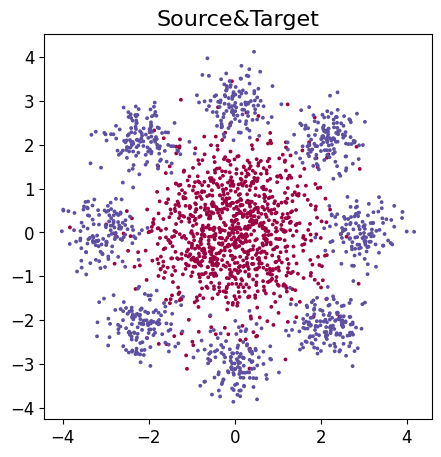

In [14]:
class Mix8GaussiansSampler(Sampler):
    def __init__(
        self, with_central=False, std=1, r=12, dim=2, device='cuda'
    ):
        super().__init__(
            device=device
        )
        assert dim == 2
        self.dim = 2
        self.std, self.r = std, r
        
        self.with_central = with_central
        centers = [
            (1, 0), (-1, 0), (0, 1), (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        if self.with_central:
            centers.append((0, 0))
        self.centers = torch.tensor(
            centers, device=self.device
        )
        
    def sample(self, batch_size=10):
        batch = torch.randn(
            batch_size, self.dim,
            device=self.device
        )
        indices = random.choices(range(len(self.centers)), k=batch_size)
        batch *= self.std
        batch += self.r * self.centers[indices, :]
        return torch.tensor(
            batch, device=self.device
        )

seed_everything()

swissroll_sampler = Mix8GaussiansSampler(device='cpu', r=3, std=0.4)
standardnormal_sampler = StandardNormalSampler(device='cpu')

source_sampler = standardnormal_sampler
target_sampler = swissroll_sampler

visualize_2d_samples_groups([
    source_sampler.sample(1024).cpu().numpy(), 
    target_sampler.sample(1024).cpu().numpy()], 'Source&Target', s=3)

In [15]:
# icnns
from ofmsrc.icnn import (
    ICNNCPF,
    ICNN2CPF,
    ICNN3CPF,
    LseICNNCPF,
    ResICNN2CPF,
    DenseICNN2CPF
)
from ofmsrc.icnn import (
    LinActnormICNN,
    DenseICNN
)

def get_model(name):
    assert name in [
        'idp',
        'mb64',
        'mb64_anti'
    ]
    # print(f"Used model: {name}")
    model = ICNN2CPF(dim=2, dimh=1024, num_hidden_layers=2, batch_size=1024, actnorm_initialized=True).to(DEVICE)
    return model

def load_model(name, device=DEVICE, beta=0):
    beta2name = {
        0: 'model.pth',
        0.99: 'model_0.99.pth',
        0.999: 'model_0.999.pth'
    }
    name2folder = {
        'idp': 'gau_v2cpf',
        'mb64': 'gau_v2cpf_mb64',
        'mb64_anti': 'gau_v2cpf_mb64_anti'
    }
    file_path = os.path.join(f'./{name2folder[name]}', beta2name[beta])
    # print(file_path)
    model = get_model(name)
    if beta == 0:
        model.load_state_dict(torch.load(file_path))
    else:
        model.load_state_dict(torch.load(file_path).state_dict())
    model.to(device)
    return model
    

In [16]:
TITLES = ['Swiss roll','Independent plan', 'MB64', 'antiMB64']
TICKS_SIZE = 14
LABEL_SIZE = 14
GRID_ALPHA = 0.2

def draw_results(models, titles=None, save_file=None):
    SEED = 12
    
    torch.manual_seed(SEED); np.random.seed(SEED)

    width = 5 * (len(models) + 1) + 4
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(width, 5.25), dpi=100, sharex=True, sharey=True)
    # fig, axes = plt.subplots(1, len(models) + 1, figsize=(width, 5.5), dpi=100, sharex=True, sharey=True)
    
    for ax in axes:
        ax.grid(zorder=-20)
    
    x_samples = source_sampler.sample(1024).cpu()
    y_samples = target_sampler.sample(1024).cpu()
    tr_samples = torch.tensor([[0.1, 0.1], [-0.5, 0.5], [2, -1], [-2, -2], [-0.7, -0.4], [0,-1], [1.5, 0.5], [0.5, 1.5], [-2.5, 0.5]]).cpu()
    
    tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(-1, 2)
    
    axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                    c="g", s=32, edgecolors="black", label = r"Input $p_0$")
    axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                    c="orange", s=32, edgecolors="black", label = r"Target $p_1$")
    axes[0].legend(loc="lower left", fontsize=LABEL_SIZE, fancybox=True, framealpha=0.95)
    axes[0].tick_params(labelsize=TICKS_SIZE, grid_alpha=GRID_ALPHA)
    
    
    for idx, ax, model in zip(list(range(len(models))), axes[1:], models):
        x_samples.requires_grad = True
        y_pred = model.push(x_samples.to(DEVICE)).cpu().detach().numpy()
        
        ax.scatter(y_pred[:, 0], y_pred[:, 1], 
                   c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)
        
        tr_samples.requires_grad = True
        trajectory = model.push(tr_samples.to(DEVICE)).cpu().detach().numpy()
        tr_samples = tr_samples.detach()
        ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
           c="g", s=128, edgecolors="black", label = r"Trajectory start ($x_0 \sim p_0$)", zorder=3)
        
        ax.scatter(trajectory[:, 0], trajectory[:, 1], 
           c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)
            
        for i in range(len(trajectory)):
            if i == 0:
                ax.plot([tr_samples[i,0],  trajectory[i, 0]  ], [tr_samples[i,1] , trajectory[i, 1]], "grey", markeredgecolor="black",
                             linewidth=2, zorder=2, label=r"Trajectory (fitted)")
            else:
                ax.plot([tr_samples[i,0],  trajectory[i, 0]  ], [tr_samples[i,1] , trajectory[i, 1]], "grey", markeredgecolor="black",
                             linewidth=2, zorder=2)
    
        # ax.legend(loc="lower left")
        if idx == 2:
            ax.legend(bbox_to_anchor=(0.5, 0.15), ncol=4, fancybox=True, fontsize=LABEL_SIZE)
        ax.tick_params(labelsize=TICKS_SIZE, grid_alpha=GRID_ALPHA)
        ax.set_xticks([-4, -2, 0, 2, 4])
        ax.set_yticks([-4, -2, 0, 2, 4])
        
    for ax in axes:
        ax.set_xlim([-4.2, 4.2])
        ax.set_ylim([-4.2, 4.2])
        # ax.legend(loc="lower left")
    if titles is not None:
        for ax, title_ in zip(axes, titles):
            ax.set_title(title_)
    if save_file is not None:
        plt.savefig(save_file)
    # fig.tight_layout(pad=1E-5)

/tmp/ipykernel_11713/848781114.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


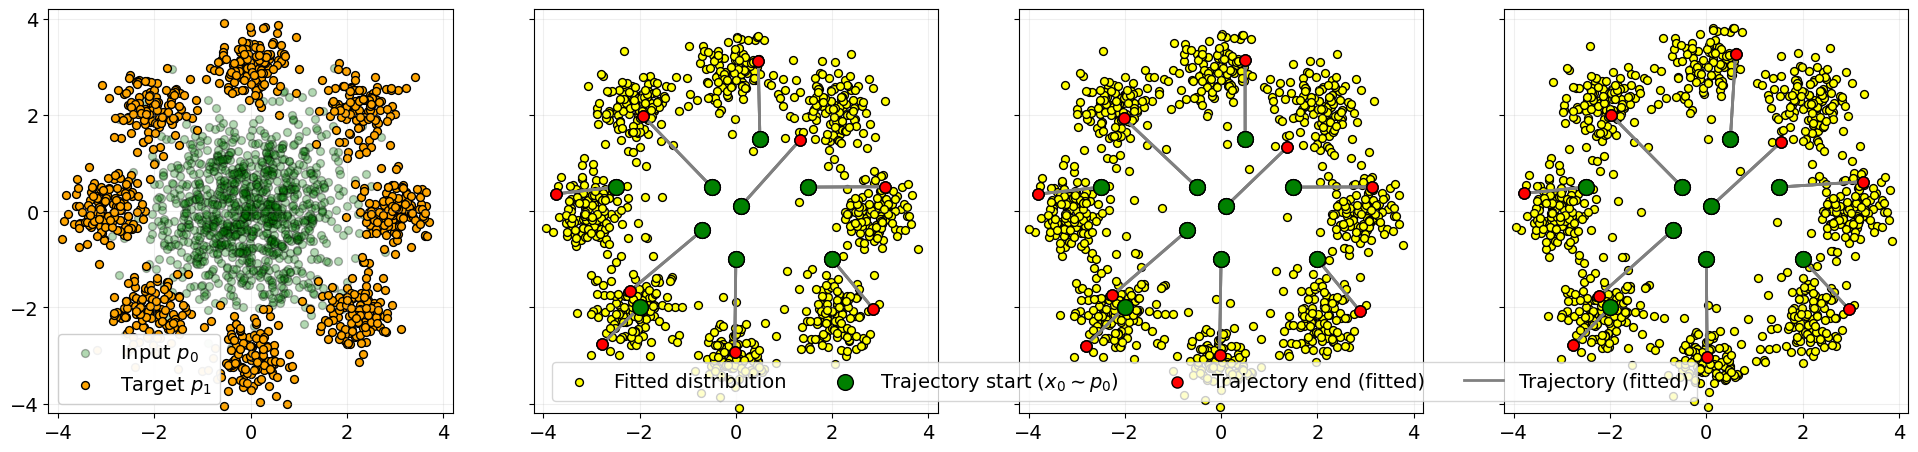

In [18]:

beta=0.0
draw_results([load_model('idp', beta=beta), load_model('mb64', beta=beta), load_model('mb64_anti', beta=beta)], titles=None, save_file=None)